In [1]:
# Execute this block to create some random non-stationary data for the remainder of this task
import numpy as np
import pandas as pd
import datetime as dt
import random as rd
from dateutil import parser
import matplotlib.pyplot as plt

def random_date(start, end):
    return (start + dt.timedelta(
        seconds=rd.randint(0, int((end - start).total_seconds())),
    )).date()
 
df_random_data = pd.DataFrame(np.random.uniform(0,1,size=(100,2)), columns=['x1','x2'])
min_date = parser.parse('1/1/2017')
max_date = parser.parse('1/11/2017')
df_random_data['AsOfDate'] = [random_date(min_date, max_date) for i in range(100)]
df_random_data['y'] = 2.0 * df_random_data.x1 + df_random_data.x2 + np.random.normal(0,0.2) + (df_random_data.AsOfDate - min_date.date()).dt.days

df_random_data.head()

,x1,x2,AsOfDate,y
0,0.803533,0.070764,2017-01-03,3.661519
1,0.450800,0.987864,2017-01-05,5.873154
2,0.155252,0.867007,2017-01-07,7.161200
3,0.403740,0.705019,2017-01-02,2.496189
4,0.146086,0.004060,2017-01-08,7.279922


In [283]:
class ChronologicalSplit:
    """Time Series out of sample splitter.
    Parameters
    ----------
    n_splits : int, default=3
        Number of splits. Must be at least 1.
    """        
    
    def __init__(self,  n_splits=3):
        self.n_splits = n_splits
        
    def split(self, dates):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        dates : array-like, of length n_samples
            The dates of the dataset, where n_samples is the number of samples
            Assume the dates will be of type datetime.date.
        Returns
        -------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        NOTES
        -----
        The following implementation is *incorrect*.  It's provided for illustration purposes only
        """       
        #creating a dataframe sorted by date and preserving its original index
        sorted_Dates = pd.DataFrame()
        sorted_Dates['Original_index'] = [i for i in range(len(dates))]
        sorted_Dates['AsOfDate'] = [date for date in (dates)]
        sorted_Dates['AsOfDate'] = pd.to_datetime(sorted_Dates.AsOfDate)
        sorted_Dates = sorted_Dates.sort_values(by=['AsOfDate'])
        
        #creating a list of unique dates in the dates array
        dates_range = np.sort(sorted_Dates.AsOfDate.unique())
        
        n_samples = len(dates_range)
        indices = np.arange(n_samples)
        indices_dates = np.arange(len(dates))
        
        #Calculating the number of dates to be included in train and test sets for each fold
        train_sizes = []
        test_sizes = []
        for i in range(1, self.n_splits+1):
            train_size = int(i * n_samples / (self.n_splits+1) )
            train_sizes.append(train_size)
            test_size = int(n_samples / (self.n_splits+1))
            test_sizes.append(test_size)
        num_folds = 0
        for train_size in range(len(train_sizes)):
            #finding the end date for training set
            try:
                last_training_date = dates_range[train_sizes[train_size]]    #last date in training set
            except:
                last_training_date = dates_range[-1]    #last date in training set

            #Finding the index of last occurence of end date in sorted_Dates samples
            last_date_indices = np.where(np.array(sorted_Dates.iloc[:, 1].values)  == last_training_date)[0]
            last_training_date_index = last_date_indices[-1]

            #get the original indices from sorted_Dates for the samples included in test set
            training_indices = []
            for index in  indices_dates[0 : last_training_date_index+1]:
                training_indices.append(sorted_Dates.iloc[index, 0])
                
            #finding the end date for test set
            test_end =  train_sizes[train_size] + test_sizes[train_size]
            try:
                last_testing_date = dates_range[test_end]    #last date in training set
            except:
                last_testing_date = dates_range[-1]
                
            #Finding the index of last occurence of end date in sorted_Dates samples
            last_test_date_indices = np.where(np.array(sorted_Dates.iloc[:, 1].values)  == last_testing_date)[0]
            last_testing_date_index = last_test_date_indices[-1]
            
            #get the original indices from sorted_Dates for the samples included in test set
            testing_indices = []
            for index in  indices_dates[last_training_date_index+1:last_testing_date_index +1]:
                testing_indices.append(sorted_Dates.iloc[index, 0])
            
            yield (training_indices, testing_indices)
            num_folds = num_folds + 1
            if num_folds == self.n_splits:
                break

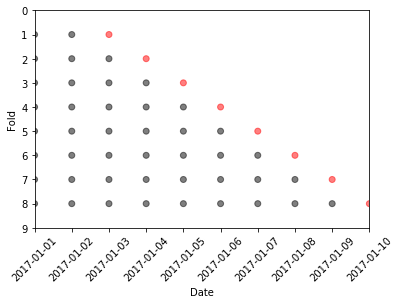

In [300]:
# Perform the split and visualize
num_splits = 8
fold_dates = []
splitter = ChronologicalSplit(n_splits=num_splits) 
splits = 0 
for train_index, test_index in splitter.split(df_random_data['AsOfDate']):
    X_train, X_test = df_random_data.iloc[train_index][['AsOfDate']] , df_random_data.iloc[test_index][['AsOfDate']]
    training_dates = X_train.AsOfDate.unique()
    testing_dates = X_test.AsOfDate.unique()
    fold_dates.append([splits, training_dates, testing_dates])    
    splits = splits+1

# Visualize the splits.  Red are the training points, blue are the testing points
%matplotlib inline
import matplotlib.pyplot as plt

df_folds = pd.DataFrame(columns=['Fold','Date','Color'])


for fold in fold_dates:
    for d in fold[1]:
        df_folds.loc[len(df_folds)]=[fold[0]+1, d, 'black']
    for d in fold[2]:
        df_folds.loc[len(df_folds)]=[fold[0]+1, d, 'red']        
     

dates = [pd.to_datetime(d) for d in df_folds['Date']]
ax = plt.scatter(dates, df_folds['Fold'],c=df_folds['Color'], alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Fold')
plt.xticks(rotation=45)
plt.ylim(0,len(fold_dates)+1.0)
plt.xlim(min(dates), max(dates))
plt.gca().invert_yaxis()

In [297]:
# Validate the splitter class
splits = 0
num_training_samples_prev = 0

for train_index, test_index in splitter.split(df_random_data['AsOfDate']):
    X_train, X_test = df_random_data.iloc[train_index][['AsOfDate']], df_random_data.iloc[test_index][['AsOfDate']]    
    training_dates = X_train.AsOfDate.unique()
    testing_dates = X_test.AsOfDate.unique()
    
    assert X_train.AsOfDate.max() < X_test.AsOfDate.min(), \
        "Training sample date %r is later than testing sample date %r" % (X_train.AsOfDate.max(),X_test.AsOfDate.min())
    assert len(X_train) > 0      
    assert len(X_train) > num_training_samples_prev
    splits = splits+1
    num_training_samples_prev = len(X_train)

assert splits == num_splits, "Num Splits = %r" % splits

In [298]:
def cross_val_predict_ts(estimator, X, y, splitter, dates):
    """Generate out of sample estimates from time series data
    Parameters
    ----------
    estimator : estimator object implementing 'fit' and 'predict'
        The object to use to fit the data.
    X : array-like, of length n_samples
        The data to fit. Can be, for example a list, or an array at least 2d.
    y : array-like, of length n_samples
        The target variable to try to predict in the case of
        supervised learning.
    dates : array-like, of length n_samples
        The dates of the dataset, where n_samples is the number of samples
        Assume the dates will be of type datetime.date.        
    splitter : object
        Implements a time series split
    Returns
    -------
    target_values: ndarray, of length < n_samples
        Subset of the y target values that were used for testing
    predictions : ndarray, of same length as target_values
        Predictions for the corresponding y values
    NOTES
    -----
    The following implementation is *incorrect*.  It's provided for illustration purposes only        
    """    
    for train_index, test_index in splitter.split(df_random_data['AsOfDate']):
        X_train, X_test = df_random_data.iloc[train_index][['x1', 'x2']], df_random_data.iloc[test_index][['x1', 'x2']]    
        y_train, y_test = df_random_data.iloc[train_index][['y']], df_random_data.iloc[test_index][['y']]
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        y_test = np.squeeze(y_test.values)
        y_pred =np.squeeze(y_pred.values)
        print('Pearson correlation and p-value:',pearsonr(y_test, y_pred))
#     y_test = np.squeeze(y_test.values)
#     y_pred =np.squeeze(y_pred.values)
    
    return (y_test, y_pred)

Pearson correlation and p-value: (0.9920739972501437, 1.2374208039512489e-06)
Pearson correlation and p-value: (0.9940384595013548, 5.486580741855997e-09)
Pearson correlation and p-value: (0.9825478524879646, 1.2382846746720565e-08)
Pearson correlation and p-value: (0.9532296598890981, 5.6616314753876794e-06)
Pearson correlation and p-value: (0.9846440205361642, 2.3881561649259767e-07)
Pearson correlation and p-value: (0.9984443105650755, 1.3492732881739085e-12)
Pearson correlation and p-value: (0.9914692796853545, 2.2933381304715947e-08)
Pearson correlation and p-value: (0.9736664611075048, 9.54200587112511e-08)


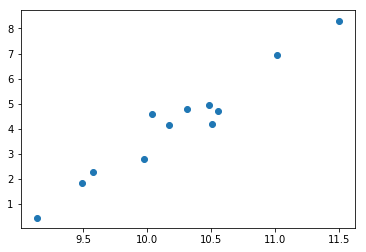

In [301]:
# Test cross_val_predict using linear regression
# This is purely for verification of that your cross_val_predict_ts() implementation executes without errors.
# It does not check for correctness.  Do not worry about the prediction performance.

import statsmodels.api as sm
class LinearEstimator: 
    
    def fit(self, X, y):
        self.linear_reg = sm.OLS(y, X)
        self.reg_res = self.linear_reg.fit()
        
    def predict(self, X):
        return self.reg_res.predict(X)
    
from scipy.stats.stats import pearsonr
estimator = LinearEstimator()
ys, preds = cross_val_predict_ts(estimator, df_random_data[['x1','x2']], df_random_data['y'], splitter, dates=df_random_data['AsOfDate'])
plt.scatter(ys, preds)                   
# print('Pearson correlation and p-value:',pearsonr(ys, preds))